<a href="https://colab.research.google.com/github/mounbagna/Bank-Management-System/blob/master/Sentimen_Analysis_of_the_Hausa_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install keras

In [36]:
import os
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
# Define functions for text preprocessing
def remove_stopwords(sentence, stopwords):
    words = sentence.lower().split()
    words = [word for word in words if word not in stopwords]
    return " ".join(words)

def tokenize(sentence):
    return word_tokenize(sentence)

def stem_words(sentence):
    # Remove 'r' and 'n' from the end of each word
    stemmed_words = [word.rstrip('rn') for word in sentence.lower().split()]
    return " ".join(stemmed_words)

def calculate_polarity(sentence, positive_words, negative_words):
    polarity = 0
    words = tokenize(sentence)

    for word in words:
        if word in positive_words:
            polarity += 1
        elif word in negative_words:
            polarity -= 1

    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Define a callback to save the best model based on validation accuracy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_cnn_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Define a function to create and train a CNN model
def train_cnn_model(X_train, y_train, X_test, y_test, max_words, max_seq_length, num_classes, epochs, callbacks=None):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_length))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

    model.fit(X_train_pad, y_train_encoded, epochs=epochs, validation_data=(X_test_pad, y_test_encoded), callbacks=callbacks)

    return model, tokenizer

In [23]:
sp = "sentence_polarity"
os.makedirs(sp, exist_ok=True)
print(f"Folder '{sp}' created successfully.")

Folder 'sentence_polarity' created successfully.


In [24]:
sw = "stopwords"
os.makedirs(sw, exist_ok=True)
print(f"Folder '{sw}' created successfully.")


Folder 'stopwords' created successfully.


In [25]:
ol = "opinion_lexicon"
os.makedirs(ol, exist_ok=True)
print(f"Folder '{ol}' created successfully.")

Folder 'opinion_lexicon' created successfully.


In [11]:
uploaded = files.upload()

Saving StopWords-HA.txt to StopWords-HA.txt


In [17]:
with open("./sentence_polarity/positive-words-HA.txt", "r") as file:
    positive_words = file.read().splitlines()

with open("./sentence_polarity/negative-words-HA.txt", "r") as file:
    negative_words = file.read().splitlines()

with open("./stopwords/StopWords-HA.txt", "r") as file:
    stopwords = file.read().splitlines()

# Read positive dataset into a DataFrame
with open('./opinion_lexicon/polarity-positive-HA.txt', 'r') as file:
    positive_data = [{'sentence': line.strip(), 'polarity': 'Positive'} for line in file]

positive_df = pd.DataFrame(positive_data)

# Read neutral dataset into a DataFrame
with open('./opinion_lexicon/polarity-neutral-HA.txt', 'r') as file:
    neutral_data = [{'sentence': line.strip(), 'polarity': 'Neutral'} for line in file]

neutral_df = pd.DataFrame(neutral_data)

# Read negative dataset into a DataFrame
with open('./opinion_lexicon/polarity-negative-HA.txt', 'r') as file:
    negative_data = [{'sentence': line.strip(), 'polarity': 'Negative'} for line in file]

negative_df = pd.DataFrame(negative_data)

In [37]:
# Calculate the total number of sentences in each dataset
total_positive_sentences = len(positive_data)
total_neutral_sentences = len(neutral_data)  # Get the number of rows (sentences)
total_negative_sentences = len(negative_data)  # Get the number of rows (sentences)

# Print the total number of sentences in each dataset
print(f"Total sentences in positive polarity dataset: {total_positive_sentences}")
print(f"Total sentences in neutral polarity dataset: {total_neutral_sentences}")
print(f"Total sentences in negative polarity dataset: {total_negative_sentences}")

Total sentences in positive polarity dataset: 5331
Total sentences in neutral polarity dataset: 5331
Total sentences in negative polarity dataset: 5331


In [19]:
# Concatenate the DataFrames into a single DataFrame
merged_dataset = pd.concat([positive_df, neutral_df, negative_df], ignore_index=True)
total_dataset = len(merged_dataset)
print(f"Total sentences in the merged dataset: {total_dataset}")

# Read and process data into a DataFrame
data = []
for sentence, polarity in zip(merged_dataset['sentence'], merged_dataset['polarity']):
    cleaned_sentence = remove_stopwords(sentence, stopwords)
    # Strip any leading or trailing white spaces or newlines from the polarity value
    polarity = polarity.strip()
    data.append({'sentence': sentence, 'cleaned_sentence': cleaned_sentence, 'polarity': polarity})

processed_df = pd.DataFrame(data)

Total sentences in the merged dataset: 15993


In [38]:
# Calculate metrics using ground truth from the merged DataFrame
accuracy = accuracy_score(processed_df['polarity'], merged_dataset['polarity'])
precision = precision_score(processed_df['polarity'], merged_dataset['polarity'], average='weighted')
recall = recall_score(processed_df['polarity'], merged_dataset['polarity'], average='weighted')
f1 = f1_score(processed_df['polarity'], merged_dataset['polarity'], average='weighted')

print("********************Polarity Lexicon Results************************************************")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



********************Polarity Lexicon Results************************************************
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [39]:
# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(processed_df['polarity'], merged_dataset['polarity'])
print("Confusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[5331    0    0]
 [   0 5331    0]
 [   0    0 5331]]


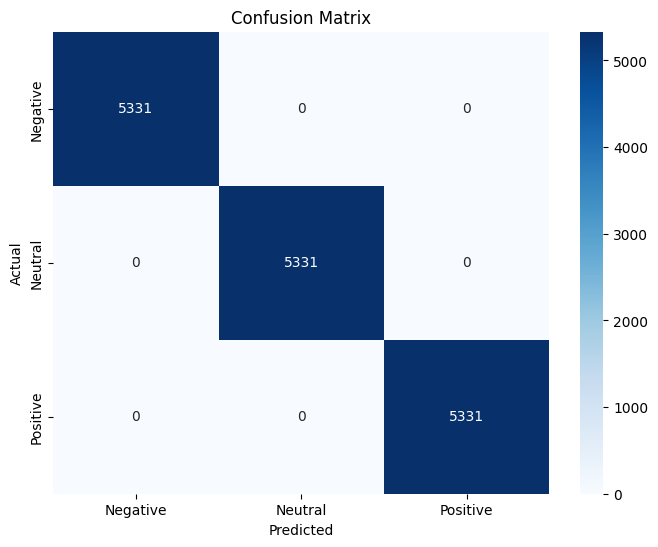

In [40]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('bow_stemmed_confusion_matrix.png')  # Save the figure as an image
plt.show()

In [22]:
# Define the desired percentage of each class in the test set
test_set_percentage = 0.2  # 20% of each class

# Separate the data by polarity
positive_samples = processed_df[processed_df['polarity'] == 'Positive']
neutral_samples = processed_df[processed_df['polarity'] == 'Neutral']
negative_samples = processed_df[processed_df['polarity'] == 'Negative']

# Split each class into train and test sets
positive_train, positive_test = train_test_split(positive_samples, test_size=test_set_percentage, random_state=42)
neutral_train, neutral_test = train_test_split(neutral_samples, test_size=test_set_percentage, random_state=42)
negative_train, negative_test = train_test_split(negative_samples, test_size=test_set_percentage, random_state=42)

# Concatenate the train and test sets for each class
X_train = pd.concat([positive_train['cleaned_sentence'], neutral_train['cleaned_sentence'], negative_train['cleaned_sentence']], ignore_index=True)
y_train = pd.concat([positive_train['polarity'], neutral_train['polarity'], negative_train['polarity']], ignore_index=True)
X_test = pd.concat([positive_test['cleaned_sentence'], neutral_test['cleaned_sentence'], negative_test['cleaned_sentence']], ignore_index=True)
y_test = pd.concat([positive_test['polarity'], neutral_test['polarity'], negative_test['polarity']], ignore_index=True)

print("Number of Neutral Test Samples:", len(neutral_test))
print("Number of Positive Test Samples:", len(positive_test))
print("Number of Negative Test Samples:", len(negative_test))

# Parameters for the CNN model
max_words = 10000  # Maximum number of words to keep
max_seq_length = 100  # Maximum sequence length (pad or truncate to this length)
num_classes = 3  # Number of classes (Negative, Neutral, Positive)
epochs = 10  # Number of training epochs

label_encoder = LabelEncoder()

# Ensure that labels are in string format
y_train = y_train.astype(str)
y_test = y_test.astype(str)

# Map label strings to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Number of runs
num_runs = 1
evaluation_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for i in range(num_runs):
    # Train the CNN model with the callback
    cnn_model, tokenizer = train_cnn_model(X_train, y_train_encoded, X_test, y_test_encoded, max_words, max_seq_length, num_classes, epochs, callbacks=[model_checkpoint])

    # Load the best CNN model
    best_cnn_model = tf.keras.models.load_model("best_cnn_model.keras")

    # Tokenize and pad the test data for prediction
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)
    X_test_pad = X_test_pad.astype(np.float32)

    # Make predictions
    y_pred_prob = cnn_model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate evaluation metrics and append to the list
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')

    evaluation_metrics['accuracy'].append(accuracy)
    evaluation_metrics['precision'].append(precision)
    evaluation_metrics['recall'].append(recall)
    evaluation_metrics['f1'].append(f1)

    print(f"Run {i + 1}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")





Number of Neutral Test Samples: 1067
Number of Positive Test Samples: 1067
Number of Negative Test Samples: 1067
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5867 - loss: 0.7842
Epoch 1: val_accuracy did not improve from 0.72196
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.5870 - loss: 0.7839 - val_accuracy: 0.6954 - val_loss: 0.6380
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7801 - loss: 0.5055
Epoch 2: val_accuracy did not improve from 0.72196
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.7801 - loss: 0.5055 - val_accuracy: 0.7135 - val_loss: 0.6333
Epoch 3/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9003 - loss: 0.2751
Epoch 3: val_accuracy did not improve from 0.72196
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9002 - loss: 0.2751 - val_accuracy: 0.7010 - val_loss: 0.7669
Epoch 4/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9653 - loss: 0.1111
Epoch 4: val_accuracy did not improve from 0.72196
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9653 - loss: 0.1111 - val_accuracy: 0.6910 - 

In [25]:
# Save performance metrics to a CSV file
performance_df = pd.DataFrame(evaluation_metrics)
performance_df.to_csv('cnn_performance.csv', index=False)

In [28]:
# Calculate mean and standard deviation of evaluation metrics
mean_metrics = {metric: np.mean(values) for metric, values in evaluation_metrics.items()}
std_metrics = {metric: np.std(values) for metric, values in evaluation_metrics.items()}

print(f"\nResults over {num_runs} runs:")
for metric in evaluation_metrics.keys():
    print(f"Mean {metric.capitalize()}: {mean_metrics[metric]} +- {std_metrics[metric]}")


Results over 1 runs:
Mean Accuracy: 0.6882224304904717 +- 0.0
Mean Precision: 0.6874504587171584 +- 0.0
Mean Recall: 0.6882224304904717 +- 0.0
Mean F1: 0.6877562274645955 +- 0.0


In [29]:
# Load the best CNN model
best_cnn_model = tf.keras.models.load_model("best_cnn_model.keras")



In [30]:
# Make predictions
y_pred_prob = best_cnn_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)



101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [31]:
# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[666  81 320]
 [ 84 923  60]
 [289  56 722]]


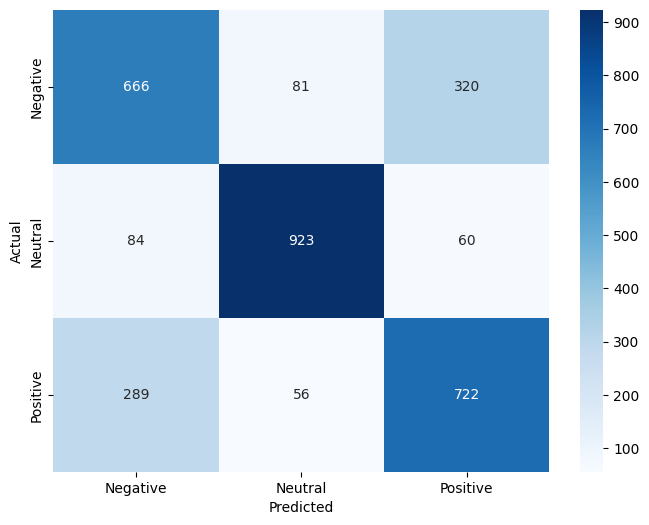

In [32]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.title('Confusion Matrix')
plt.savefig('cnn_confusion_matrix.png')  # Save the figure as an image
plt.show()